In [1]:
# Import main libraries
import pandas as pd
import math
import numpy as np
import zipfile

# Import libraries for plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Import library for requests
import requests
import os
url = 'http://api.openweathermap.org/data/2.5/forecast?'
parameters = {'q': 'Chicago', 'units': 'metric', 'appid': os.getenv('openweather_api_key')}

# To be able to pull the API key from the .env, we need to import and run the load_dotenv function from the dotenv module first.
from dotenv import load_dotenv
load_dotenv()

# Set time period for prediction model
from datetime import datetime
start_date = datetime(2020, 11, 1, 0, 0)
end_date = datetime(2023, 8, 31, 23, 59)

### Get free 3 hourly weather forecast for the next 5 days from Openweathermap ###

In [2]:
# Request data from url
r = requests.get(url, parameters)    
# Decode response with json decoder
weather_temp = r.json()
# Transform list into DatFrame
df_list = list(weather_temp['list'])
df_weather_forecast = pd.json_normalize(df_list)
df_weather_forecast
# Calculate local Chicago time
df_weather_forecast['datetime'] = pd.to_datetime(df_weather_forecast['dt'] - 18000, unit='s')
# If weather forecast doesn't contain rain or snow, create new columns with '0' values:
if not 'rain.3h' in df_weather_forecast.columns:
    df_weather_forecast['rain.3h'] = 0.0
if not 'snow.3h' in df_weather_forecast.columns:
    df_weather_forecast['snow.3h'] = 0.0
# Clean-up and prepare weather forecast DataFrame
df_weather_forecast = df_weather_forecast[['datetime', 'main.temp', 'main.feels_like', 'wind.speed', 'wind.deg', 'wind.gust', 'rain.3h', 'snow.3h']]
df_weather_forecast.rename(columns={"main.temp": "temp", "main.feels_like": "feels_like", "wind.speed": "wind_speed", "wind.deg": "wind_deg", "wind.gust": "wind_gust", "rain.3h": "rain_3h", "snow.3h": "snow_3h"}, inplace=True)
df_weather_forecast['datetime'] = pd.to_datetime(df_weather_forecast['datetime'])
# Calculate wind speeds in km/h
df_weather_forecast['wind_speed'] = df_weather_forecast['wind_speed'] / 60
df_weather_forecast['wind_gust'] = df_weather_forecast['wind_gust'] / 60
df_weather_forecast.rename(columns={"wind_speed": "wind_speed_km_h", "wind_gust": "wind_gust_km_h"}, inplace=True)
df_weather_forecast['rain_3h'].fillna(0, inplace=True)
df_weather_forecast.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   datetime         40 non-null     datetime64[ns]
 1   temp             40 non-null     float64       
 2   feels_like       40 non-null     float64       
 3   wind_speed_km_h  40 non-null     float64       
 4   wind_deg         40 non-null     int64         
 5   wind_gust_km_h   40 non-null     float64       
 6   rain_3h          40 non-null     float64       
 7   snow_3h          40 non-null     float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 2.6 KB


### Plot weatherforecast: ###

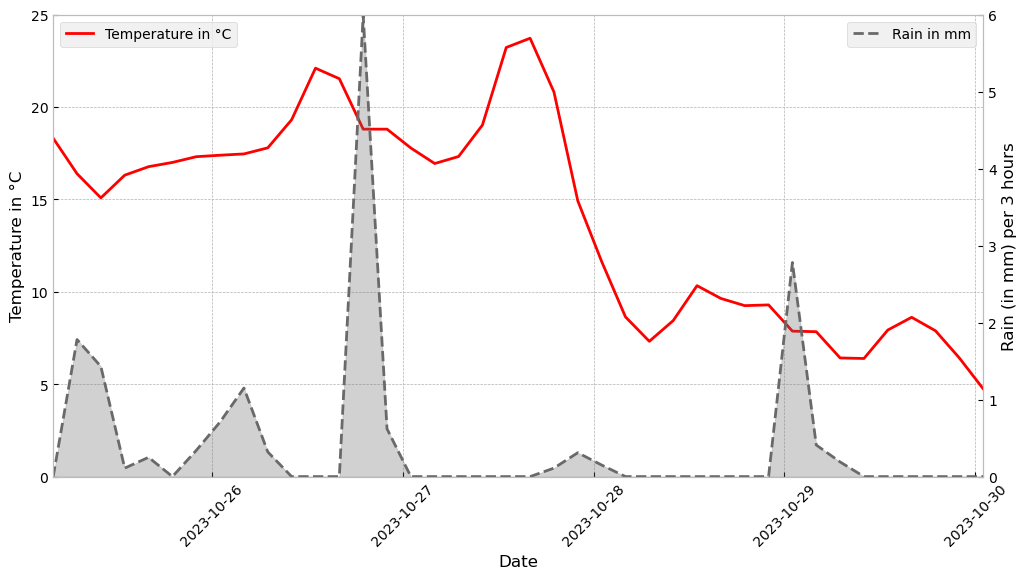

In [3]:
# Set general parameters for diagram
plt.style.use('bmh')
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_facecolor('white')
# Set temperature for main axis
temp = ax1.plot(df_weather_forecast['datetime'], df_weather_forecast['temp'], color='red')
ax1.set_ylabel('Temperature in °C')
# Set temperature y-axis according to values in 5 °C intervals
temp_max = (math.ceil(df_weather_forecast['temp'].max()) // 5 + 1) * 5
temp_min = (math.floor(df_weather_forecast['temp'].min()) // 5) * 5
ax1.set_ylim(temp_min, temp_max)        
# Set datetime x-axis with day intervals
ax1.set_xlabel('Date')
ax1.set_xlim(df_weather_forecast['datetime'].min(), df_weather_forecast['datetime'].max())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.DayLocator())
ax1.legend(['Temperature in °C'], loc="upper left")
plt.xticks(rotation=45, fontweight='light')

# Set secondary y-axis with rain/snow if existent
if (df_weather_forecast['rain_3h'].max() > 0) or (df_weather_forecast['snow_3h'].max() > 0):
    ax2 = ax1.twinx()
    if (df_weather_forecast['rain_3h'].max() > 0) and (df_weather_forecast['snow_3h'].max() == 0):
        ax2.set_ylabel('Rain (in mm) per 3 hours')
        ax2.set_ylim(0, math.ceil(df_weather_forecast['rain_3h'].max()))
        rain = ax2.plot(df_weather_forecast['datetime'], df_weather_forecast['rain_3h'], color='dimgrey', linestyle='--')
        ax2.legend(['Rain in mm'], loc="upper right")
    elif (df_weather_forecast['rain_3h'].max() == 0) and (df_weather_forecast['snow_3h'].max() > 0):
        ax2.set_ylabel('Snow (in mm) per 3 hours')
        ax2.set_ylim(0, math.ceil(df_weather_forecast['snow_3h'].max()))
        snow = ax2.plot(df_weather_forecast['datetime'], df_weather_forecast['snow_3h'], color='greenyellow', linestyle='--')
        ax2.legend(['Snow in mm'], loc="upper right")
    else:
        ax2.set_ylabel('Precipitation (in mm) per 3 hours')
        rain = ax2.plot(df_weather_forecast['datetime'], df_weather_forecast['rain_3h'], color='dimgrey', linestyle='--')
        snow = ax2.plot(df_weather_forecast['datetime'], df_weather_forecast['snow_3h'], color='greenyellow', linestyle='--')
        if df_weather_forecast['rain_3h'].max() > df_weather_forecast['snow_3h'].max() > 0:
            ax2.set_ylim(0, math.ceil(df_weather_forecast['rain_3h'].max()))
        else:
            ax2.set_ylim(0, math.ceil(df_weather_forecast['snow_3h'].max()))
        ax2.legend(['Rain in mm', 'Snow in mm'], loc="upper right")
    if (df_weather_forecast['rain_3h'].max() > 0):
        plt.fill_between(df_weather_forecast['datetime'], df_weather_forecast['rain_3h'], color='dimgrey', alpha=0.3)
    if (df_weather_forecast['snow_3h'].max() > 0):
        plt.fill_between(df_weather_forecast['datetime'], df_weather_forecast['snow_3h'], color='greenyellow', alpha=0.3)
    ax2.grid(False)

# Show diagram
plt.show();

### Create interpolated, hourly weather forecast from original weather forecast ###

In [4]:
# Create interpolated, 1 hourly weather forecast
df_temp = pd.DataFrame(pd.Series(pd.date_range(start=df_weather_forecast['datetime'].min(), end=df_weather_forecast['datetime'].max(), freq="h")))
df_temp.rename(columns={0: "datetime"}, inplace=True)

df_generated = df_temp.merge(df_weather_forecast, how='outer', on='datetime')
df_generated['temp'] = df_generated['temp'].interpolate()
df_generated['temp'] = round(df_generated['temp'], 1)
df_generated['feels_like'] = df_generated['feels_like'].interpolate()
df_generated['feels_like'] = round(df_generated['feels_like'], 1)
df_generated['wind_speed_km_h'] = df_generated['wind_speed_km_h'].interpolate()
df_generated['wind_speed_km_h'] = round(df_generated['wind_speed_km_h'], 1)
df_generated['wind_deg'] = df_generated['wind_deg'].interpolate()
df_generated['wind_deg'] = round(df_generated['wind_deg'], 1)
df_generated['wind_gust_km_h'] = df_generated['wind_gust_km_h'].interpolate()
df_generated['wind_gust_km_h'] = round(df_generated['wind_gust_km_h'], 1)
df_generated['rain_3h'] = df_generated['rain_3h'].interpolate()
df_generated['rain_3h'] = df_generated['rain_3h'] / 3
df_generated.rename(columns={"rain_3h": "rain_1h"}, inplace=True)
df_generated['rain_1h'] = round(df_generated['rain_1h'], 1)
df_generated['snow_3h'] = df_generated['snow_3h'].interpolate()
df_generated['snow_3h'] = df_generated['snow_3h'] / 3
df_generated.rename(columns={"snow_3h": "snow_1h"}, inplace=True)
df_generated['snow_1h'] = round(df_generated['snow_1h'], 1)
df_generated['year'] = df_generated['datetime'].dt.year
df_generated['month'] = df_generated['datetime'].dt.month
df_generated['day'] = df_generated['datetime'].dt.day
df_generated['hour'] = df_generated['datetime'].dt.hour
df_generated['dayofweek'] = df_generated['datetime'].dt.dayofweek
df_generated['predicted_rides'] = 0
df_generated.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   datetime         118 non-null    datetime64[ns]
 1   temp             118 non-null    float64       
 2   feels_like       118 non-null    float64       
 3   wind_speed_km_h  118 non-null    float64       
 4   wind_deg         118 non-null    float64       
 5   wind_gust_km_h   118 non-null    float64       
 6   rain_1h          118 non-null    float64       
 7   snow_1h          118 non-null    float64       
 8   year             118 non-null    int32         
 9   month            118 non-null    int32         
 10  day              118 non-null    int32         
 11  hour             118 non-null    int32         
 12  dayofweek        118 non-null    int32         
 13  predicted_rides  118 non-null    int64         
dtypes: datetime64[ns](1), float64(7), int32(5)

### Get trips and weather data from csv-files in 'data' directory: ###

In [5]:
# Read relevant csv-files with cleaned bike-trips from zip-file:
df = pd.DataFrame
zf = zipfile.ZipFile('data/trips.zip')
trips_list = ['trips_2020.csv', 'trips_2021.csv', 'trips_2022.csv', 'trips_2023.csv']

for i in range(0, len(trips_list)):
    if i == 0:
        df = pd.read_csv(zf.open(trips_list[i]), low_memory=False)
    else:
        df_temp = pd.read_csv(zf.open(trips_list[i]), low_memory=False)
        df = pd.concat([df, df_temp])
del trips_list
# Cleanup DataFrame
df.drop(columns=['Unnamed: 0', 'start_station_name', 'start_station_lat', 'start_station_lon', 'end_station_name', 'end_station_lat', 'end_station_lon'], inplace=True)
df['starttime'] = pd.to_datetime(df['starttime'], yearfirst=True)

df_temp = df[(df['starttime'] >= start_date) & (df['starttime'] <= end_date)]
df_temp.reset_index(drop=True, inplace=True)
df = df_temp
del df_temp
# Show content of DataFrame
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13332777 entries, 0 to 13332776
Data columns (total 4 columns):
 #   Column               Non-Null Count     Dtype         
---  ------               --------------     -----         
 0   starttime            13332777 non-null  datetime64[ns]
 1   tripduration_in_min  13332777 non-null  float64       
 2   customer             13332777 non-null  object        
 3   rideable_type        13332777 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 406.9+ MB


In [6]:
# Create column with full hours datetime
df['year'] = df['starttime'].dt.year
df['month'] = df['starttime'].dt.month
df['day'] = df['starttime'].dt.day
df['hour'] = df['starttime'].dt.hour
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']], format='%Y-%m-%d %H:00')
df.drop(columns=['year', 'month', 'day'], inplace=True)
# Create column rides_count
df_agg = df.groupby(['datetime'])[['tripduration_in_min']].count()
df_agg.rename(columns={'tripduration_in_min': 'rides_count'}, inplace=True)
df_agg.reset_index(drop=False, inplace=True)
# Create columns with customers and bike_types
df_types = df
df_types['casuals'] = np.where(df_types['customer'] == 'casual', 1, 0)
df_types['members'] = np.where(df_types['customer'] == 'member', 1, 0)
df_types['docked_bikes'] = np.where(df_types['rideable_type'] == 'docked_bike', 1, 0)
df_types['classic_bikes'] = np.where(df_types['rideable_type'] == 'classic_bike', 1, 0)
df_types['electric_bikes'] = np.where(df_types['rideable_type'] == 'electric_bike', 1, 0)
df_types_sum = df_types.groupby(['datetime'])[['casuals', 'members', 'docked_bikes', 'classic_bikes', 'electric_bikes']].sum()
df_types_sum.reset_index(drop=False, inplace=True)
df_types_sum
# Merge DataFrames
df_trips = df_agg.merge(df_types_sum, how='left', on='datetime')
del df
del df_agg
del df_types
del df_types_sum
df_trips.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24791 entries, 0 to 24790
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime        24791 non-null  datetime64[ns]
 1   rides_count     24791 non-null  int64         
 2   casuals         24791 non-null  int32         
 3   members         24791 non-null  int32         
 4   docked_bikes    24791 non-null  int32         
 5   classic_bikes   24791 non-null  int32         
 6   electric_bikes  24791 non-null  int32         
dtypes: datetime64[ns](1), int32(5), int64(1)
memory usage: 871.7 KB


In [7]:
# Create weather DataFrame
df_weather = pd.read_csv('data/chicago_weather.csv')
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])
df_weather = df_weather[(df_weather['datetime'] >= start_date) & (df_weather['datetime'] <= end_date)]
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24813 entries, 64409 to 89221
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   datetime         24813 non-null  datetime64[ns]
 1   temp             24813 non-null  float64       
 2   rain_1h          24813 non-null  float64       
 3   snow_1h          24813 non-null  float64       
 4   wind_deg         24813 non-null  int64         
 5   wind_speed_km_h  24813 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 1.3 MB


In [8]:
# Merge hourly trips with weather
df_full = df_weather.merge(df_trips, how='left', on='datetime')
df_full['rides_count'].fillna(0, inplace=True)

In [9]:
# Check for national US holidays. If the day is a holiday the function returns True
def is_holiday(date):
    from pandas.tseries.holiday import USFederalHolidayCalendar
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start='2020-01-01', end='2023-12-31')
    return date in holidays

In [10]:
df_temp = df_full[['datetime', 'temp', 'rain_1h', 'snow_1h', 'rides_count']].copy()
df_temp['hour'] = df_temp['datetime'].dt.hour
df_temp['dayofweek'] = df_temp['datetime'].dt.dayofweek
df_temp.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24813 entries, 0 to 24812
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     24813 non-null  datetime64[ns]
 1   temp         24813 non-null  float64       
 2   rain_1h      24813 non-null  float64       
 3   snow_1h      24813 non-null  float64       
 4   rides_count  24813 non-null  float64       
 5   hour         24813 non-null  int32         
 6   dayofweek    24813 non-null  int32         
dtypes: datetime64[ns](1), float64(4), int32(2)
memory usage: 1.1 MB


In [11]:
# Create Sub-DataFrames for dry weather and different rain and snow situations
df_no_precipitation = df_temp[(df_temp['rain_1h'] <= 0.25) & (df_temp['snow_1h'] == 0)]
df_light_rain = df_temp[(df_temp['rain_1h'] > 0.25) & (df_temp['rain_1h'] <= 0.75) & (df_temp['snow_1h'] == 0)]
df_moderate_rain = df_temp[(df_temp['rain_1h'] > 0.75) & (df_temp['rain_1h'] <= 1.5) & (df_temp['snow_1h'] == 0)]
df_heavy_rain = df_temp[(df_temp['rain_1h'] > 1.5) & (df_temp['rain_1h'] <= 3) & (df_temp['snow_1h'] == 0)]
df_very_heavy_rain = df_temp[(df_temp['rain_1h'] > 3) & (df_temp['snow_1h'] == 0)]
df_light_snow = df_temp[(df_temp['snow_1h'] > 0) & (df_temp['snow_1h'] <= 0.25)]
df_moderate_snow = df_temp[(df_temp['snow_1h'] > 0.25) & (df_temp['snow_1h'] <= 0.5)]
df_heavy_snow = df_temp[(df_temp['snow_1h'] > 0.5)]

In [12]:
# Function to create hourly, average ride_counts for specific temperature ranges
# separated by working-days (Mon-Fri) and workday-days (Sat-Sun) / holidays
def conditions_rides(df, days: str):
    # Filtering:
    if days == 'workdays':
        df_range = df[(df['dayofweek'] <= 4)]
    else:
        df_range = df[(df['dayofweek'] > 4)]
    # Create empty DataFRame with column 'hour'
    hour_list = []
    for i in range(24):
        hour_list.append(i)
    df_hours = pd.DataFrame(hour_list)
    df_hours.rename(columns = {0: 'hour'}, inplace=True)
    # Creating temperature chunk < -15°C:
    df_temp_range = df_range[(df_range['temp'] < -15)]
    df_temp_grouped = df_temp_range.groupby(['hour'])[['rides_count']].mean()
    df_temp_grouped.rename(columns = {'rides_count': 'rides_<-15'}, inplace=True)
    df_grouped = df_hours.merge(df_temp_grouped, on='hour', how='left')
    # Creating temperature chunk >= -15°C and < -10°C:
    df_temp_range = df_range[(df_range['temp'] >= -15) & (df_range['temp'] < -10)]
    df_temp_grouped = df_temp_range.groupby(['hour'])[['rides_count']].mean()
    df_temp_grouped.rename(columns = {'rides_count': 'rides_-15_-10'}, inplace=True)
    df_grouped = df_grouped.merge(df_temp_grouped, on='hour', how='left')
    # Creating temperature chunk >= -10°C and < -5°C:
    df_temp_range = df_range[(df_range['temp'] >= -10) & (df_range['temp'] < -5)]
    df_temp_grouped = df_temp_range.groupby(['hour'])[['rides_count']].mean()
    df_temp_grouped.rename(columns = {'rides_count': 'rides_-10_-5'}, inplace=True)
    df_grouped = df_grouped.merge(df_temp_grouped, on='hour', how='left')
    # Creating temperature chunk >= -5°C and < 0°C:
    df_temp_range = df_range[(df_range['temp'] >= -5) & (df_range['temp'] < 0)]
    df_temp_grouped = df_temp_range.groupby(['hour'])[['rides_count']].mean()
    df_temp_grouped.rename(columns = {'rides_count': 'rides_-5_0'}, inplace=True)
    df_grouped = df_grouped.merge(df_temp_grouped, on='hour', how='left')
    # Creating temperature chunk >= 0°C and < 5°C:
    df_temp_range = df_range[(df_range['temp'] >= 0) & (df_range['temp'] < 5)]
    df_temp_grouped = df_temp_range.groupby(['hour'])[['rides_count']].mean()
    df_temp_grouped.rename(columns = {'rides_count': 'rides_0_5'}, inplace=True)
    df_grouped = df_grouped.merge(df_temp_grouped, on='hour', how='left')
    # Creating temperature chunk >= 5°C and < 10°C:
    df_temp_range = df_range[(df_range['temp'] >= 5) & (df_range['temp'] < 10)]
    df_temp_grouped = df_temp_range.groupby(['hour'])[['rides_count']].mean()
    df_temp_grouped.rename(columns = {'rides_count': 'rides_5_10'}, inplace=True)
    df_grouped = df_grouped.merge(df_temp_grouped, on='hour', how='left')
    # Creating temperature chunk >= 10°C and < 15°C:
    df_temp_range = df_range[(df_range['temp'] >= 10) & (df_range['temp'] < 15)]
    df_temp_grouped = df_temp_range.groupby(['hour'])[['rides_count']].mean()
    df_temp_grouped.rename(columns = {'rides_count': 'rides_10_15'}, inplace=True)
    df_grouped = df_grouped.merge(df_temp_grouped, on='hour', how='left')
    # Creating temperature chunk >= 15°C and < 20°C:
    df_temp_range = df_range[(df_range['temp'] >= 15) & (df_range['temp'] < 20)]
    df_temp_grouped = df_temp_range.groupby(['hour'])[['rides_count']].mean()
    df_temp_grouped.rename(columns = {'rides_count': 'rides_15_20'}, inplace=True)
    df_grouped = df_grouped.merge(df_temp_grouped, on='hour', how='left')
    # Creating temperature chunk >= 20°C:
    df_temp_range = df_range[(df_range['temp'] >= 20)]
    df_temp_grouped = df_temp_range.groupby(['hour'])[['rides_count']].mean()
    df_temp_grouped.rename(columns = {'rides_count': 'rides_>20'}, inplace=True)
    df_grouped = df_grouped.merge(df_temp_grouped, on='hour', how='left')    
    # Interpolate missing values in each row
    #df_grouped = df_grouped.interpolate(method='polynomial', order=2, axis=0)
    df_grouped = df_grouped.interpolate(method='linear', axis=0)
    # Change columns data to integer
    df_grouped['rides_<-15'] = round(df_grouped['rides_<-15'], 0)
    df_grouped['rides_-15_-10'] = round(df_grouped['rides_-15_-10'], 0)
    df_grouped['rides_-10_-5'] = round(df_grouped['rides_-10_-5'], 0)
    df_grouped['rides_-5_0'] = round(df_grouped['rides_-5_0'], 0)
    df_grouped['rides_0_5'] = round(df_grouped['rides_0_5'], 0)
    df_grouped['rides_5_10'] = round(df_grouped['rides_5_10'], 0)
    df_grouped['rides_10_15'] = round(df_grouped['rides_10_15'], 0)
    df_grouped['rides_15_20'] = round(df_grouped['rides_15_20'], 0)
    df_grouped['rides_>20'] = round(df_grouped['rides_>20'], 0)

    return df_grouped

In [13]:
df_no_prec_workday = conditions_rides(df_no_precipitation, 'workdays')
df_no_prec_weekend = conditions_rides(df_no_precipitation, 'weekend')
df_light_rain_workday = conditions_rides(df_light_rain, 'workdays')
df_light_rain_weekend = conditions_rides(df_light_rain, 'weekend')
df_moderate_rain_workday = conditions_rides(df_moderate_rain, 'workdays')
df_moderate_rain_weekend = conditions_rides(df_moderate_rain, 'weekend')
df_heavy_rain_workday = conditions_rides(df_heavy_rain, 'workdays')
df_heavy_rain_weekend = conditions_rides(df_heavy_rain, 'weekend')
df_very_heavy_rain_workday = conditions_rides(df_very_heavy_rain, 'workdays')
df_very_heavy_rain_weekend = conditions_rides(df_very_heavy_rain, 'weekend')
df_light_snow_workday = conditions_rides(df_light_snow, 'workdays')
df_light_snow_weekend = conditions_rides(df_light_snow, 'weekend')
df_moderate_snow_workday = conditions_rides(df_moderate_snow, 'workdays')
df_moderate_snow_weekend = conditions_rides(df_moderate_snow, 'weekend')
df_heavy_snow_workday = conditions_rides(df_heavy_snow, 'workdays')
df_heavy_snow_weekend = conditions_rides(df_heavy_snow, 'weekend')

In [14]:
df_predicted = df_generated
# Add column with predicted_rides per hour
for i, row in df_predicted.iterrows():
    # Values for working days:
    if (row['dayofweek'] <= 4) and (is_holiday(row['datetime'].floor('d')) == False):
        if row['temp'] < -15:
            if (row['snow_1h'] > 0) and (row['snow_1h'] <= 0.25): df_predicted.at[i,'predicted_rides'] = df_light_snow_workday.at[df_predicted.at[i,'hour'], 'rides_<-15']
            elif (row['snow_1h'] > 0.25) and (row['snow_1h'] <= 0.5): df_predicted.at[i,'predicted_rides'] = df_moderate_snow_workday.at[df_predicted.at[i,'hour'], 'rides_<-15']
            elif (row['snow_1h'] > 0.5): df_predicted.at[i,'predicted_rides'] = df_heavy_snow_workday.at[df_predicted.at[i,'hour'], 'rides_<-15']
            else: df_predicted.at[i,'predicted_rides'] = df_no_prec_workday.at[df_predicted.at[i,'hour'], 'rides_<-15']
        elif (row['temp'] >= -15) and (row['temp'] < -10):
            if (row['snow_1h'] > 0) and (row['snow_1h'] <= 0.25): df_predicted.at[i,'predicted_rides'] = df_light_snow_workday.at[df_predicted.at[i,'hour'], 'rides_-15_-10']
            elif (row['snow_1h'] > 0.25) and (row['snow_1h'] <= 0.5): df_predicted.at[i,'predicted_rides'] = df_moderate_snow_workday.at[df_predicted.at[i,'hour'], 'rides_-15_-10']
            elif (row['snow_1h'] > 0.5): df_predicted.at[i,'predicted_rides'] = df_heavy_snow_workday.at[df_predicted.at[i,'hour'], 'rides_-15_-10']
            else: df_predicted.at[i,'predicted_rides'] = df_no_prec_workday.at[df_predicted.at[i,'hour'], 'rides_-15_-10']
        elif (row['temp'] >= -10) and (row['temp'] < -5):
            if (row['snow_1h'] > 0) and (row['snow_1h'] <= 0.25): df_predicted.at[i,'predicted_rides'] = df_light_snow_workday.at[df_predicted.at[i,'hour'], 'rides_-10_-5']
            elif (row['snow_1h'] > 0.25) and (row['snow_1h'] <= 0.5): df_predicted.at[i,'predicted_rides'] = df_moderate_snow_workday.at[df_predicted.at[i,'hour'], 'rides_-10_-5']
            elif (row['snow_1h'] > 0.5): df_predicted.at[i,'predicted_rides'] = df_heavy_snow_workday.at[df_predicted.at[i,'hour'], 'rides_-10_-5']
            else: df_predicted.at[i,'predicted_rides'] = df_no_prec_workday.at[df_predicted.at[i,'hour'], 'rides_-10_-5']
        elif (row['temp'] >= -5) and (row['temp'] < 0):
            if (row['snow_1h'] > 0) and (row['snow_1h'] <= 0.25): df_predicted.at[i,'predicted_rides'] = df_light_snow_workday.at[df_predicted.at[i,'hour'], 'rides_-5_0']
            elif (row['snow_1h'] > 0.25) and (row['snow_1h'] <= 0.5): df_predicted.at[i,'predicted_rides'] = df_moderate_snow_workday.at[df_predicted.at[i,'hour'], 'rides_-5_0']
            elif (row['snow_1h'] > 0.5): df_predicted.at[i,'predicted_rides'] = df_heavy_snow_workday.at[df_predicted.at[i,'hour'], 'rides_-5_0']
            else: df_predicted.at[i,'predicted_rides'] = df_no_prec_workday.at[df_predicted.at[i,'hour'], 'rides_-5_0']
        elif (row['temp'] >= 0) and (row['temp'] < 5):
            if (row['snow_1h'] > 0) and (row['snow_1h'] <= 0.25): df_predicted.at[i,'predicted_rides'] = df_light_snow_workday.at[df_predicted.at[i,'hour'], 'rides_0_5']
            elif (row['snow_1h'] > 0.25) and (row['snow_1h'] <= 0.5): df_predicted.at[i,'predicted_rides'] = df_moderate_snow_workday.at[df_predicted.at[i,'hour'], 'rides_0_5']
            elif (row['snow_1h'] > 0.5): df_predicted.at[i,'predicted_rides'] = df_heavy_snow_workday.at[df_predicted.at[i,'hour'], 'rides_0_5']
            elif (row['rain_1h'] > 0.25) and (row['rain_1h'] <= 0.75): df_predicted.at[i,'predicted_rides'] = df_light_rain_workday.at[df_predicted.at[i,'hour'], 'rides_0_5']
            elif (row['rain_1h'] > 0.75) and (row['rain_1h'] <= 1.5): df_predicted.at[i,'predicted_rides'] = df_moderate_rain_workday.at[df_predicted.at[i,'hour'], 'rides_0_5']
            elif (row['rain_1h'] > 1.5) and (row['rain_1h'] <= 3): df_predicted.at[i,'predicted_rides'] = df_heavy_rain_workday.at[df_predicted.at[i,'hour'], 'rides_0_5']
            elif (row['rain_1h'] > 3): df_predicted.at[i,'predicted_rides'] = df_very_heavy_rain_workday.at[df_predicted.at[i,'hour'], 'rides_0_5']
            else: df_predicted.at[i,'predicted_rides'] = df_no_prec_workday.at[df_predicted.at[i,'hour'], 'rides_0_5']
        elif (row['temp'] >= 5) and (row['temp'] < 10):
            if (row['rain_1h'] > 0.25) and (row['rain_1h'] <= 0.75): df_predicted.at[i,'predicted_rides'] = df_light_rain_workday.at[df_predicted.at[i,'hour'], 'rides_5_10']
            elif (row['rain_1h'] > 0.75) and (row['rain_1h'] <= 1.5): df_predicted.at[i,'predicted_rides'] = df_moderate_rain_workday.at[df_predicted.at[i,'hour'], 'rides_5_10']
            elif (row['rain_1h'] > 1.5) and (row['rain_1h'] <= 3): df_predicted.at[i,'predicted_rides'] = df_heavy_rain_workday.at[df_predicted.at[i,'hour'], 'rides_5_10']
            elif (row['rain_1h'] > 3): df_predicted.at[i,'predicted_rides'] = df_very_heavy_rain_workday.at[df_predicted.at[i,'hour'], 'rides_5_10']
            else: df_predicted.at[i,'predicted_rides'] = df_no_prec_workday.at[df_predicted.at[i,'hour'], 'rides_5_10']
        elif (row['temp'] >= 10) and (row['temp'] < 15):
            if (row['rain_1h'] > 0.25) and (row['rain_1h'] <= 0.75): df_predicted.at[i,'predicted_rides'] = df_light_rain_workday.at[df_predicted.at[i,'hour'], 'rides_10_15']
            elif (row['rain_1h'] > 0.75) and (row['rain_1h'] <= 1.5): df_predicted.at[i,'predicted_rides'] = df_moderate_rain_workday.at[df_predicted.at[i,'hour'], 'rides_10_15']
            elif (row['rain_1h'] > 1.5) and (row['rain_1h'] <= 3): df_predicted.at[i,'predicted_rides'] = df_heavy_rain_workday.at[df_predicted.at[i,'hour'], 'rides_10_15']
            elif (row['rain_1h'] > 3): df_predicted.at[i,'predicted_rides'] = df_very_heavy_rain_workday.at[df_predicted.at[i,'hour'], 'rides_10_15']
            else: df_predicted.at[i,'predicted_rides'] = df_no_prec_workday.at[df_predicted.at[i,'hour'], 'rides_10_15']
        elif (row['temp'] >= 15) and (row['temp'] < 20):
            if (row['rain_1h'] > 0.25) and (row['rain_1h'] <= 0.75): df_predicted.at[i,'predicted_rides'] = df_light_rain_workday.at[df_predicted.at[i,'hour'], 'rides_15_20']
            elif (row['rain_1h'] > 0.75) and (row['rain_1h'] <= 1.5): df_predicted.at[i,'predicted_rides'] = df_moderate_rain_workday.at[df_predicted.at[i,'hour'], 'rides_15_20']
            elif (row['rain_1h'] > 1.5) and (row['rain_1h'] <= 3): df_predicted.at[i,'predicted_rides'] = df_heavy_rain_workday.at[df_predicted.at[i,'hour'], 'rides_15_20']
            elif (row['rain_1h'] > 3): df_predicted.at[i,'predicted_rides'] = df_very_heavy_rain_workday.at[df_predicted.at[i,'hour'], 'rides_15_20']
            else: df_predicted.at[i,'predicted_rides'] = df_no_prec_workday.at[df_predicted.at[i,'hour'], 'rides_15_20']
        elif (row['temp'] >= 20):
            if (row['rain_1h'] > 0.25) and (row['rain_1h'] <= 0.75): df_predicted.at[i,'predicted_rides'] = df_light_rain_workday.at[df_predicted.at[i,'hour'], 'rides_>20']
            elif (row['rain_1h'] > 0.75) and (row['rain_1h'] <= 1.5): df_predicted.at[i,'predicted_rides'] = df_moderate_rain_workday.at[df_predicted.at[i,'hour'], 'rides_>20']
            elif (row['rain_1h'] > 1.5) and (row['rain_1h'] <= 3): df_predicted.at[i,'predicted_rides'] = df_heavy_rain_workday.at[df_predicted.at[i,'hour'], 'rides_>20']
            elif (row['rain_1h'] > 3): df_predicted.at[i,'predicted_rides'] = df_very_heavy_rain_workday.at[df_predicted.at[i,'hour'], 'rides_>20']
            else: df_predicted.at[i,'predicted_rides'] = df_no_prec_workday.at[df_predicted.at[i,'hour'], 'rides_>20']
    # Values for weekends and holidays
    else:
        if row['temp'] < -15:
            if (row['snow_1h'] > 0) and (row['snow_1h'] <= 0.25): df_predicted.at[i,'predicted_rides'] = df_light_snow_weekend.at[df_predicted.at[i,'hour'], 'rides_<-15']
            elif (row['snow_1h'] > 0.25) and (row['snow_1h'] <= 0.5): df_predicted.at[i,'predicted_rides'] = df_moderate_snow_weekend.at[df_predicted.at[i,'hour'], 'rides_<-15']
            elif (row['snow_1h'] > 0.5): df_predicted.at[i,'predicted_rides'] = df_heavy_snow_weekend.at[df_predicted.at[i,'hour'], 'rides_<-15']
            else: df_predicted.at[i,'predicted_rides'] = df_no_prec_weekend.at[df_predicted.at[i,'hour'], 'rides_<-15']
        elif (row['temp'] >= -15) and (row['temp'] < -10):
            if (row['snow_1h'] > 0) and (row['snow_1h'] <= 0.25): df_predicted.at[i,'predicted_rides'] = df_light_snow_weekend.at[df_predicted.at[i,'hour'], 'rides_-15_-10']
            elif (row['snow_1h'] > 0.25) and (row['snow_1h'] <= 0.5): df_predicted.at[i,'predicted_rides'] = df_moderate_snow_weekend.at[df_predicted.at[i,'hour'], 'rides_-15_-10']
            elif (row['snow_1h'] > 0.5): df_predicted.at[i,'predicted_rides'] = df_heavy_snow_weekend.at[df_predicted.at[i,'hour'], 'rides_-15_-10']
            else: df_predicted.at[i,'predicted_rides'] = df_no_prec_weekend.at[df_predicted.at[i,'hour'], 'rides_-15_-10']
        elif (row['temp'] >= -10) and (row['temp'] < -5):
            if (row['snow_1h'] > 0) and (row['snow_1h'] <= 0.25): df_predicted.at[i,'predicted_rides'] = df_light_snow_weekend.at[df_predicted.at[i,'hour'], 'rides_-10_-5']
            elif (row['snow_1h'] > 0.25) and (row['snow_1h'] <= 0.5): df_predicted.at[i,'predicted_rides'] = df_moderate_snow_weekend.at[df_predicted.at[i,'hour'], 'rides_-10_-5']
            elif (row['snow_1h'] > 0.5): df_predicted.at[i,'predicted_rides'] = df_heavy_snow_weekend.at[df_predicted.at[i,'hour'], 'rides_-10_-5']
            else: df_predicted.at[i,'predicted_rides'] = df_no_prec_weekend.at[df_predicted.at[i,'hour'], 'rides_-10_-5']
        elif (row['temp'] >= -5) and (row['temp'] < 0):
            if (row['snow_1h'] > 0) and (row['snow_1h'] <= 0.25): df_predicted.at[i,'predicted_rides'] = df_light_snow_weekend.at[df_predicted.at[i,'hour'], 'rides_-5_0']
            elif (row['snow_1h'] > 0.25) and (row['snow_1h'] <= 0.5): df_predicted.at[i,'predicted_rides'] = df_moderate_snow_weekend.at[df_predicted.at[i,'hour'], 'rides_-5_0']
            elif (row['snow_1h'] > 0.5): df_predicted.at[i,'predicted_rides'] = df_heavy_snow_weekend.at[df_predicted.at[i,'hour'], 'rides_-5_0']
            else: df_predicted.at[i,'predicted_rides'] = df_no_prec_weekend.at[df_predicted.at[i,'hour'], 'rides_-5_0']
        elif (row['temp'] >= 0) and (row['temp'] < 5):
            if (row['snow_1h'] > 0) and (row['snow_1h'] <= 0.25): df_predicted.at[i,'predicted_rides'] = df_light_snow_weekend.at[df_predicted.at[i,'hour'], 'rides_0_5']
            elif (row['snow_1h'] > 0.25) and (row['snow_1h'] <= 0.5): df_predicted.at[i,'predicted_rides'] = df_moderate_snow_weekend.at[df_predicted.at[i,'hour'], 'rides_0_5']
            elif (row['snow_1h'] > 0.5): df_predicted.at[i,'predicted_rides'] = df_heavy_snow_weekend.at[df_predicted.at[i,'hour'], 'rides_0_5']
            elif (row['rain_1h'] > 0.25) and (row['rain_1h'] <= 0.75): df_predicted.at[i,'predicted_rides'] = df_light_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_0_5']
            elif (row['rain_1h'] > 0.75) and (row['rain_1h'] <= 1.5): df_predicted.at[i,'predicted_rides'] = df_moderate_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_0_5']
            elif (row['rain_1h'] > 1.5) and (row['rain_1h'] <= 3): df_predicted.at[i,'predicted_rides'] = df_heavy_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_0_5']
            elif (row['rain_1h'] > 3): df_predicted.at[i,'predicted_rides'] = df_very_heavy_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_0_5']
            else: df_predicted.at[i,'predicted_rides'] = df_no_prec_weekend.at[df_predicted.at[i,'hour'], 'rides_0_5']
        elif (row['temp'] >= 5) and (row['temp'] < 10):
            if (row['rain_1h'] > 0.25) and (row['rain_1h'] <= 0.75): df_predicted.at[i,'predicted_rides'] = df_light_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_5_10']
            elif (row['rain_1h'] > 0.75) and (row['rain_1h'] <= 1.5): df_predicted.at[i,'predicted_rides'] = df_moderate_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_5_10']
            elif (row['rain_1h'] > 1.5) and (row['rain_1h'] <= 3): df_predicted.at[i,'predicted_rides'] = df_heavy_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_5_10']
            elif (row['rain_1h'] > 3): df_predicted.at[i,'predicted_rides'] = df_very_heavy_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_5_10']
            else: df_predicted.at[i,'predicted_rides'] = df_no_prec_weekend.at[df_predicted.at[i,'hour'], 'rides_5_10']
        elif (row['temp'] >= 10) and (row['temp'] < 15):
            if (row['rain_1h'] > 0.25) and (row['rain_1h'] <= 0.75): df_predicted.at[i,'predicted_rides'] = df_light_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_10_15']
            elif (row['rain_1h'] > 0.75) and (row['rain_1h'] <= 1.5): df_predicted.at[i,'predicted_rides'] = df_moderate_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_10_15']
            elif (row['rain_1h'] > 1.5) and (row['rain_1h'] <= 3): df_predicted.at[i,'predicted_rides'] = df_heavy_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_10_15']
            elif (row['rain_1h'] > 3): df_predicted.at[i,'predicted_rides'] = df_very_heavy_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_10_15']
            else: df_predicted.at[i,'predicted_rides'] = df_no_prec_weekend.at[df_predicted.at[i,'hour'], 'rides_10_15']
        elif (row['temp'] >= 15) and (row['temp'] < 20):
            if (row['rain_1h'] > 0.25) and (row['rain_1h'] <= 0.75): df_predicted.at[i,'predicted_rides'] = df_light_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_15_20']
            elif (row['rain_1h'] > 0.75) and (row['rain_1h'] <= 1.5): df_predicted.at[i,'predicted_rides'] = df_moderate_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_15_20']
            elif (row['rain_1h'] > 1.5) and (row['rain_1h'] <= 3): df_predicted.at[i,'predicted_rides'] = df_heavy_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_15_20']
            elif (row['rain_1h'] > 3): df_predicted.at[i,'predicted_rides'] = df_very_heavy_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_15_20']
            else: df_predicted.at[i,'predicted_rides'] = df_no_prec_weekend.at[df_predicted.at[i,'hour'], 'rides_15_20']
        elif (row['temp'] >= 20):
            if (row['rain_1h'] > 0.25) and (row['rain_1h'] <= 0.75): df_predicted.at[i,'predicted_rides'] = df_light_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_>20']
            elif (row['rain_1h'] > 0.75) and (row['rain_1h'] <= 1.5): df_predicted.at[i,'predicted_rides'] = df_moderate_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_>20']
            elif (row['rain_1h'] > 1.5) and (row['rain_1h'] <= 3): df_predicted.at[i,'predicted_rides'] = df_heavy_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_>20']
            elif (row['rain_1h'] > 3): df_predicted.at[i,'predicted_rides'] = df_very_heavy_rain_weekend.at[df_predicted.at[i,'hour'], 'rides_>20']
            else: df_predicted.at[i,'predicted_rides'] = df_no_prec_weekend.at[df_predicted.at[i,'hour'], 'rides_>20']
df_predicted.drop(columns=['year', 'month', 'day', 'hour', 'dayofweek'], inplace=True)
df_predicted.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   datetime         118 non-null    datetime64[ns]
 1   temp             118 non-null    float64       
 2   feels_like       118 non-null    float64       
 3   wind_speed_km_h  118 non-null    float64       
 4   wind_deg         118 non-null    float64       
 5   wind_gust_km_h   118 non-null    float64       
 6   rain_1h          118 non-null    float64       
 7   snow_1h          118 non-null    float64       
 8   predicted_rides  116 non-null    float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 8.4 KB


### Plot diagram with predicted trips: ###

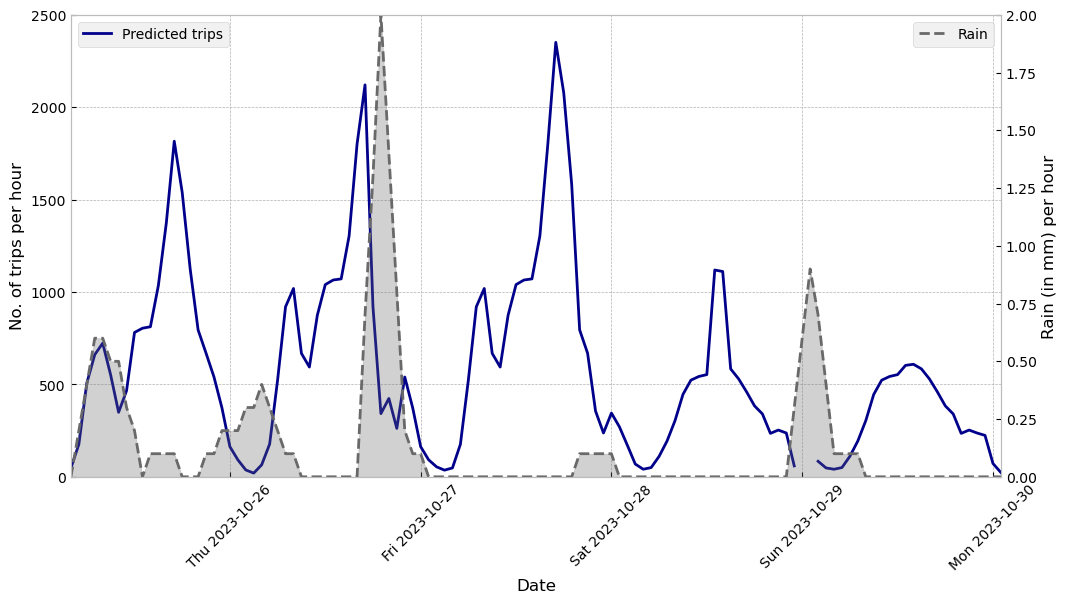

In [15]:
# Plot DataFrame with whole week
plt.style.use('bmh')
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.set_facecolor('white')
# Set predicted rides for main axis
predicted_rides = ax1.plot(df_predicted['datetime'], df_predicted['predicted_rides'], color='darkblue')
ax1.set_ylabel('No. of trips per hour')
# Set predicted rides y-axis according to values in 500 rides intervals
rides_max = (math.ceil(df_predicted['predicted_rides'].max()) // 500 + 1) * 500
ax1.set_ylim(0, rides_max)  
# Set datetime x-axis with day intervals
ax1.set_xlabel('Date')
ax1.set_xlim(df_predicted['datetime'].min(), df_predicted['datetime'].max())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%a %Y-%m-%d'))
ax1.xaxis.set_major_locator(mdates.DayLocator())
ax1.legend(['Predicted trips'], loc="upper left")
plt.xticks(rotation=45, fontweight='light')

# Set secondary y-axis with rain/snow if existent
if (df_predicted['rain_1h'].max() > 0) or (df_predicted['snow_1h'].max() > 0):
    ax2 = ax1.twinx()
    if (df_predicted['rain_1h'].max() > 0) and (df_predicted['snow_1h'].max() == 0):
        ax2.set_ylabel('Rain (in mm) per hour')
        ax2.set_ylim(0, math.ceil(df_predicted['rain_1h'].max()))
        rain = ax2.plot(df_predicted['datetime'], df_predicted['rain_1h'], color='dimgrey', linestyle='--')
        ax2.legend(['Rain'], loc="upper right")
    elif (df_predicted['rain_1h'].max() == 0) and (df_predicted['snow_1h'].max() > 0):
        ax2.set_ylabel('Snow (in mm) per hour')
        ax2.set_ylim(0, math.ceil(df_predicted['snow_1h'].max()))
        snow = ax2.plot(df_predicted['datetime'], df_predicted['snow_1h'], color='greenyellow', linestyle='--')
        ax2.legend(['Snow'], loc="upper right")
    else:
        ax2.set_ylabel('Precipitation (in mm) per hour')
        rain = ax2.plot(df_predicted['datetime'], df_predicted['rain_1h'], color='dimgrey', linestyle='--')
        snow = ax2.plot(df_predicted['datetime'], df_predicted['snow_1h'], color='greenyellow', linestyle='--')
        if df_predicted['rain_1h'].max() > df_predicted['snow_1h'].max() > 0:
            ax2.set_ylim(0, math.ceil(df_predicted['rain_1h'].max()))
        else:
            ax2.set_ylim(0, math.ceil(df_predicted['snow_1h'].max()))
        ax2.legend(['Rain', 'Snow'], loc="upper right")
    ax2.grid(False)
    if (df_predicted['rain_1h'].max() > 0):
        plt.fill_between(df_predicted['datetime'], df_predicted['rain_1h'], color='dimgrey', alpha=0.3)
    if (df_predicted['snow_1h'].max() > 0):
        plt.fill_between(df_predicted['datetime'], df_predicted['snow_1h'], color='greenyellow', alpha=0.3)

# Show diagram
plt.show();